# Continuous Bag of Words (CBOW) Implementation
## as part of Udacity Deep Learning Course

In [1]:
#Imports
import tensorflow as tf; print(tf.__version__)  # for Python 3
import collections
import math
import numpy as np
import os
import random
import zipfile
from six.moves.urllib.request import urlretrieve
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pylab
from sklearn.manifold import TSNE

W0912 19:00:38.761566 140002978572096 deprecation.py:323] From /home/shrey/anaconda3/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


2.2.0


In [2]:
#Load Dataset and split into words
# 'text8' dataset from http://mattmahoney.net/dc/

url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  #Download a file if not present, and make sure it's the right size.
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

def read_data(filename):
  #Extract the first file enclosed in a zip file as a list of words
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)

Found and verified text8.zip


In [3]:
#Build the dictionary and replace rare words with UNK token.

vocab_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocab_size - 1))
    dictionary = dict()
    for word,_ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count+=1
        data.append(index)
    count[0][1] = unk_count
    reverse_dict = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dict

data, count, dictionary, reverse_dict = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [4]:
#%%  Function to generate batches for CBOW model

data_index = 0
def gen_batch(batch_size, skip_window):
    global data_index
    assert skip_window%2==1
    span = 2*skip_window + 1
    batch = np.ndarray(shape=(batch_size,span-1), dtype = np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype = np.int32)
    buffer = collections.deque(maxlen = span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index+1) % len(data)
    
    for i in range(batch_size):
        target = skip_window
        col_idx=0
        for j in range(span):
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j]
            col_idx+=1
        labels[i,0] = buffer[target]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]==span-1
    return batch, labels

In [5]:
#%%  TF Model

batch_size = 128
embedding_size = 128
skip_window = 3
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window), valid_size//2))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/device:GPU:0'):
    #Input
    train_dataset = tf.placeholder(tf.int32, shape = [batch_size, 2*skip_window])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    #Variables
    embeddings = tf.Variable(tf.random_uniform([vocab_size,embedding_size],-1.0,1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocab_size]))
    
    #Model
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)

    embed = None
    for i in range(2*skip_window):
        ecurr = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])
        embx, emby = ecurr.get_shape().as_list()
        if embed is None:
            embed = tf.reshape(ecurr, [embx, emby,1])
        else:
            embed = tf.concat([embed, tf.reshape(ecurr, [embx, emby,1])], 2)

    assert embed.get_shape().as_list()[2]==2*skip_window
    avg_embed = tf.reduce_mean(embed,2,keep_dims=False)

    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights = softmax_weights, biases = softmax_biases, inputs = avg_embed, labels = train_labels, num_sampled = num_sampled, num_classes = vocab_size))
    
    #optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    

W0912 19:00:47.198362 140002978572096 deprecation.py:506] From /home/shrey/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/adagrad.py:77: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0912 19:00:47.228832 140002978572096 deprecation.py:506] From <ipython-input-5-201f3c9cb876>:45: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
#%% Session
    
num_steps = 100001

with tf.Session(graph=graph,config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    avg_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = gen_batch(batch_size, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict = feed_dict)
        avg_loss += l
        if step%2000==0 and step>0:
            avg_loss = avg_loss/2000
            print('Average loss at step %d: %f' % (step, avg_loss))
            avg_loss = 0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dict[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dict[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
    

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0

Initialized
Nearest to of: hafnium, mapquest, gradually, remainder, lightsabers, unarmed, pestis, lurking,
Nearest to will: score, raj, stances, tamburlaine, bioko, authentic, eleusis, hunan,
Nearest to only: sulla, sopra, detector, divination, adolf, diatessaron, photius, napster,
Nearest to also: selim, supplemental, late, wir, britannicus, otherness, shebaa, empowerment,
Nearest to th: cholas, glottalized, mckean, gendarmerie, erp, southeast, commanding, bruges,
Nearest to so: tapioca, gunfight, appellations, switching, ssel, moynihan, temples, symbol,
Nearest to no: halliwell, transuranic, federalism, legitimate, absolutely, exegetical, dwelling, mindat,
Nearest to the: curia, fraternities,

Average loss at step 52000: 3.168604
Average loss at step 54000: 3.196152
Average loss at step 56000: 3.084879
Average loss at step 58000: 3.152569
Average loss at step 60000: 3.139653
Nearest to of: cpan, concerning, russo, turbulent, oriente, throughout, plausible, inquiring,
Nearest to will: would, must, should, could, can, may, might, cannot,
Nearest to only: always, adad, spinet, tattoo, facilitates, subcontinent, computationally, no,
Nearest to also: geothermal, britannicus, raspberry, still, below, prophetess, vih, researched,
Nearest to th: nineteenth, nd, twentieth, keystroke, gendarmerie, ulrike, handoff, psalm,
Nearest to so: jong, napkin, too, pops, uneasy, flexibility, musketeers, canes,
Nearest to no: any, little, hateful, dwelling, federalism, only, aussie, specialise,
Nearest to the: another, alexandria, a, jockeys, forti, this, backstreet, its,
Nearest to which: that, this, when, where, these, what, thrillers, ghc,
Nearest to b: d, mark, granny, n, q, nascar, airman, c

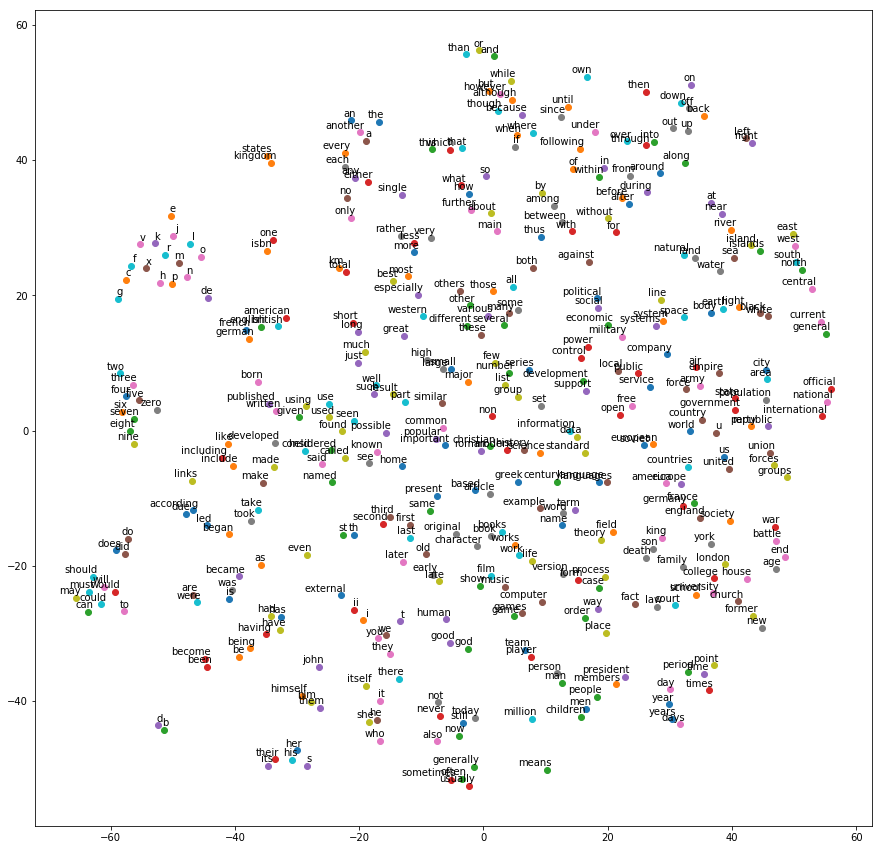

In [8]:
#%% Visualization using TSNE

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dict[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)